In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MATHGR5430 Final Project

> Group Member: Sebastian Tao



## 1 Portfolio optimization example

###1.1 Load Packages

In [2]:
import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math

###1.2 Load Data

The model data has already been pre-processed from text files and saved into pickle files. Loading and parsing the raw files (parsing text into numbers) can slow down your backtest significantly, which is why it is important to pre-process the data beforehand.

In [3]:
model_dir = '/content/drive/My Drive/Fall_2023/MATH5430/FACTOR_MODEL/'

def sort_cols(test):
    return(test.reindex(sorted(test.columns), axis=1))

frames = {}
for year in [2004,2005,2006]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pd.read_pickle(fil))

for x in frames:
    frames[x] = sort_cols(frames[x])

covariance = {}
for year in [2003,2004,2005,2006]:
    fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
    covariance.update(pd.read_pickle(fil))

ID: a unique identifier that can be used to link stocks across time\
1DREVRSL: very short-term reversal, potential alpha factor but probably too fast-moving to be tradable\
STREVRSL: short-term reversal, potential alpha factor\
LTREVRSL: long-term reversal, potential alpha factor\
BETA: risk factor computed from CAPM beta regression\
EARNQLTY: earnings quality, potential alpha factor\
EARNYILD: earnings yield (blend of forecasted earnings and historical earnings divided by market cap)\
GROWTH: mix of historical and forecasted earnings growth\
INDMOM: industry momentum (defined as relative historical outperformance or underperformance of the other stocks in the same industry)\
LEVERAGE: financial leverage of the company's balance sheet, usually a risk factor\
LIQUIDTY: factor with high loadings for very liquidly traded names; usually a risk factor\
MGMTQLTY: management quality, potential alpha factor which looks at quantitative measures of how well-run a company is by its management\
MOMENTUM: 12-month growth in stock price, usually a risk factor\
PROFIT: profitability, potential alpha factor\
PROSPECT: based on skewness of the return distribution, potential risk factor\
RESVOL: risk factor computed from residual volatility\
SEASON: seasonality-based alpha factor\
SENTMT: news sentiment alpha factor\
SIZE: risk factor based on log(market capitalization)\
VALUE: risk factor based on ratio of tangible book value to current price\
SpecRisk: specific risk is another name for predicted residual volatility. We called this the D matrix in our discussion of APT models.\
TotalRisk: predicted total vol, including factor and idiosyncratic contributions, annualized\
Ret: asset's total return on the next day after the factor loadings are known, suitable as the Y vector in a regression analysis\
Yield: the dividend yield of the asset\
HistBeta: historically estimated CAPM beta coeﬀicient PredBeta: model-predicted beta coeﬀicient in the future\
IssuerMarketCap: aggregate market capitalization of the company (all share classes from the same issuer, e.g. for Google would include both Alphabet A and C)\
BidAskSpread: bid-offer spread (average for the day)\
CompositeVolume: composite trading volume for the day\
DataDate: the date when the data would have been known, as of the close
Many of the remaining columns are industry factors, of which a full list is given below.\

In [4]:
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
      'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG',
      'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
      'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
      'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
      'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE',
      'INTERNET',
      'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
      'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP',
      'PAPER', 'PHARMA', 'PRECMTLS','PSNLPROD','REALEST',
      'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE',
      'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT',
      'WIRELESS']
style_factors = ['BETA','SIZE','MOMENTUM','VALUE','LEVERAGE','LIQUIDTY']

###1.3 Data Cleaning and Winsorization

The distribution of many statistics can be heavily influenced by outliers. A simple approach to robustifying parameter estimation procedures is to set all outliers to a specified percentile of the data; for example, a 90% winsorization would see all data below the 5th percentile set to the 5th percentile, and data above the 95th percentile set to the 95th percentile. Winsorized estimators are usually more robust to outliers than their more standard forms.

In [5]:
def wins(x,a,b):
    return(np.where(x <= a,a, np.where(x >= b, b, x)))

def clean_nas(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    for numeric_column in numeric_columns:
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    return df

We can check the distribution of returns with a density plot, both before and after winsorization to observe the effect of trimming the tails.

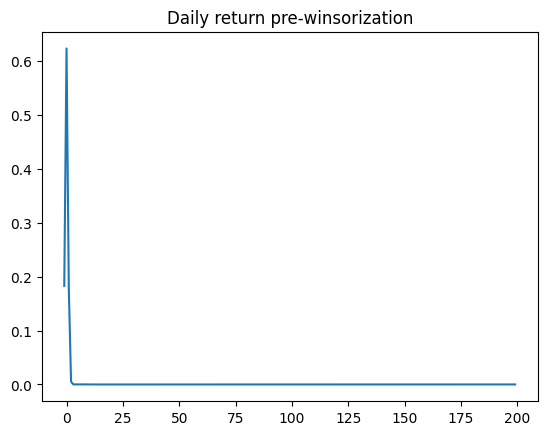

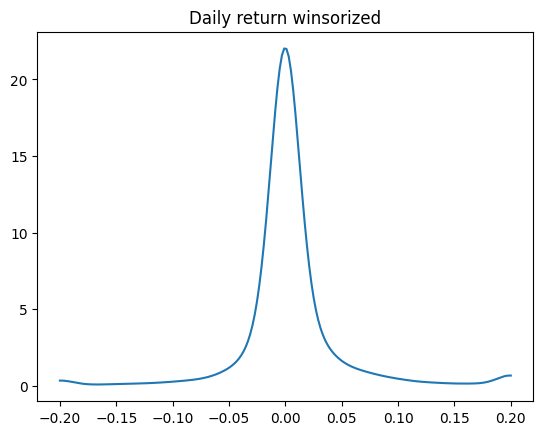

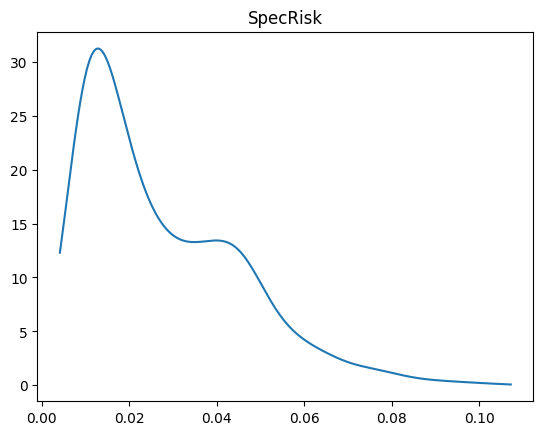

In [6]:
def density_plot(data, title):
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.title(title)
    plt.show()

test = frames['20040102']
density_plot(test['Ret'], 'Daily return pre-winsorization')
density_plot(wins(test['Ret'],-0.2,0.2), 'Daily return winsorized')

D = (test['SpecRisk'] / (100 * math.sqrt(252))) ** 2
density_plot(np.sqrt(D), 'SpecRisk')

## 2 Factors

### 2.1 Factor Exposures and Factor Returns

>$r_i = \beta_{i, 1} f_1 + ... + \beta_{i, p} f_p + \epsilon_i, \quad \epsilon \sim N(0, \sigma_i^2)$




> $R_{t+1} = X_t f_{t+1} + \epsilon_{t+1}, \quad E[\epsilon] = 0, \quad V[\epsilon] = D$

> $E[f] = \mu_f$, and $V[f] = F$

In [7]:
def get_estu(df):
    """
    Estimation universe definition
    """
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
    return estu

def colnames(X):
    """
    return names of columns, for DataFrame or DesignMatrix
    """
    if(type(X) == patsy.design_info.DesignMatrix):
        return(X.design_info.column_names)
    if(type(X) == pandas.core.frame.DataFrame):
        return(X.columns.tolist())
    return(None)

def diagonal_factor_cov(date, X):
    """
    Factor covariance matrix, ignoring off-diagonal for simplicity
    """
    cv = covariance[date]
    k = np.shape(X)[1]
    Fm = np.zeros([k,k])
    for j in range(0,k):
        fac = colnames(X)[j]
        Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0]
    return(Fm)

def risk_exposures(estu):
    """
    Exposure matrix for risk factors, usually called X in class
    """
    L = ["0"]
    L.extend(style_factors)
    L.extend(industry_factors)
    my_formula = " + ".join(L)
    return patsy.dmatrix(my_formula, data = estu)

#### 2.1.1 Helpful code to show how to get X, F, D matrices

In [8]:
my_date = '20040102'

# estu = estimation universe
estu = get_estu(frames[my_date])
estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)

rske = risk_exposures(estu)
F = diagonal_factor_cov(my_date, rske)
X = np.asarray(rske)
D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )

kappa = 1e-5

candidate_alphas = [
    'STREVRSL', 'LTREVRSL', 'INDMOM',
    'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']

#### 2.1.2 Problem 0

All of the below pertain to the estimation universe as defined above. Modify the daily data frames, removing all non-estimation-universe rows, before continuing.


In [9]:
Date = list(frames.keys())
estus = {}
for date in Date:
    estu = get_estu(frames[date])
    estus[date] = estu

#### 2.1.3 Problem 1

**Residual returns** Within each daily data frame, let $Y$ denote the residuals of the variable Ret, with respect to the risk model. In other words, define\
$$Y = Ret - XX^{+}Ret$$
where $X^{+}$ denotes the pseudoinverse, and $X$ is constructed as above (ie. using the risk_exposures function). Augment the data frames you have been given, by adding a new column, $Y$, to each frame. Be sure to winsorize the $Ret$ column prior to computing $Y$ as above. You do not have to save the augmented data, unless you want to. In other words, the modification that adds column $Y$ can be done in-memory.

In [10]:
def residual_returns(estu):
    #get Winsorised returns
    ret = estu['Ret'].copy(deep = True)
    ret_transformed = wins(ret, -0.25, 0.25)

    #get X
    rske = risk_exposures(estu)
    X = np.asarray(rske)

    #get predicted Winsorised returns
    pred = X @ (np.linalg.pinv(X)) @ ret_transformed

    return ret_transformed - pred


for date in Date:
    estus[date]['Y'] = residual_returns(estus[date])

#### 2.1.4 Problem 2

**Model selection** Split your data into a training/validation set
$D_{train}$, and an ultimate test set (vault), $D_{test}$. Do not split within a single day; rather, some dates end up in $D_{train}$ and the rest in $D_{test}$. This will be the basis of your cross-validation study later on.\
It will be helpful to join together vertically the frames in the training/validation set $D_{train}$ into a single frame called a panel. For the avoidance of doubt, the panel will have the same columns as any one of the daily frames individually, and the panel will have a large number of rows (the sum of all the rows of all the frames in $D_{train}$).\
Consider list of candidate alpha factors given above. Find a model of the form
$$Y = f( \text{candidate alphas} ) + \epsilon$$
where $Y$ is the residual return from above. Determine the function $f()$ using cross-validation to optimize any tunable hyper-parameters. First, to get started, assume $f$ is linear and use lasso or elastic net cross-validation tools (e.g. from sklearn). Then, get creative and try at least one non- linear functional form for $f$, again using cross-validation to optimize any tunable hyper-parameters.

In [15]:
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

In [12]:
"""
Split and transform dataset for supervised learning problem
"""
def to_split(test_size, Date):
    train_idx = round(len(Date)*(1-test_size))
    Date_shuffled = shuffle(Date, random_state = 0)
    train_date, test_date = Date_shuffled[:train_idx], Date_shuffled[train_idx:]
    return train_date, test_date

def to_supervised(train_date, estus, candidate_alphas):
    train = [estus[date] for date in train_date]
    train_panel = pd.concat(train, axis=0)
    train_panel = train_panel.reset_index(drop=True)
    X_train = train_panel.loc[:, candidate_alphas]
    y_train = train_panel['Y']
    return X_train, y_train

train_date, test_date = to_split(0.3, Date)
X_train, y_train = to_supervised(train_date, estus, candidate_alphas)
X_test, y_test = to_supervised(test_date, estus, candidate_alphas)

Baseline (Lasso)

In [14]:
alphas = np.logspace(-10, 0, 10)
clfs = []
for alpha in alphas:
    clf = Lasso(alpha = alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    pred_train = clf.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    pred_test = clf.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    print(f'for alpha = {alpha}, the mse for the train set is {mse_train} and the mse for the test set is {mse_test}')
    important_features = [feature for feature, coef in zip(X_train.columns, clf.coef_) if coef != 0]
    print(important_features)

for alpha = 1e-10, the mse for the train set is 0.00027985665200109063 and the mse for the test set is 0.00028743968311118617
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha = 1.2915496650148826e-09, the mse for the train set is 0.0002798566520011065 and the mse for the test set is 0.0002874396833206614
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha = 1.6681005372000592e-08, the mse for the train set is 0.0002798566520038449 and the mse for the test set is 0.00028743968594150874
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha = 2.1544346900318867e-07, the mse for the train set is 0.0002798566524930919 and the mse for the test set is 0.00028743971784667404
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha = 2.782559402207126e-06, the mse fo

Elastic Net

In [18]:
l1ratio = np.logspace(-10, 0, 5)
alphas = np.logspace(-10, -5, 5)
regrs = []
for alpha in alphas:
    for l1 in l1ratio:
        regr = ElasticNet(alpha = alpha, l1_ratio = l1)
        regr.fit(X_train, y_train)
        regrs.append(regr)
        pred_train = regr.predict(X_train)
        mse_train = mean_squared_error(y_train, pred_train)
        pred_test = regr.predict(X_test)
        mse_test = mean_squared_error(y_test, pred_test)
        print(f'for alpha, l1 = {alpha},{l1}, the mse for the train set is {mse_train} and the mse for the test set is {mse_test}')
        important_features = [feature for feature, coef in zip(X_train.columns, regr.coef_) if coef != 0]
        print(important_features)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e+02, tolerance: 3.716e-02
  model = cd_fast.enet_coordinate_descent(


for alpha, l1 = 1e-10,1e-10, the mse for the train set is 0.00027985665200109063 and the mse for the test set is 0.0002874396830926542
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha, l1 = 1e-10,3.162277660168379e-08, the mse for the train set is 0.00027985665200109063 and the mse for the test set is 0.0002874396830926542
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha, l1 = 1e-10,1e-05, the mse for the train set is 0.00027985665200109026 and the mse for the test set is 0.0002874396830926544
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha, l1 = 1e-10,0.0031622776601683794, the mse for the train set is 0.0002798566520010904 and the mse for the test set is 0.0002874396830927083
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha, l1 = 1e-10,1.0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+01, tolerance: 3.716e-02
  model = cd_fast.enet_coordinate_descent(


for alpha, l1 = 1.7782794100389228e-09,1e-10, the mse for the train set is 0.0002798566520010904 and the mse for the test set is 0.0002874396830926822
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha, l1 = 1.7782794100389228e-09,3.162277660168379e-08, the mse for the train set is 0.0002798566520010904 and the mse for the test set is 0.0002874396830926822
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha, l1 = 1.7782794100389228e-09,1e-05, the mse for the train set is 0.0002798566520010904 and the mse for the test set is 0.00028743968309268556
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
for alpha, l1 = 1.7782794100389228e-09,0.0031622776601683794, the mse for the train set is 0.0002798566520010906 and the mse for the test set is 0.0002874396830936069
['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', '

XGBoost with L1L2

In [19]:
import xgboost as xgb

In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [21]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 4,
    # 'alpha': 1e-7,
    # 'lambda': 2,
    'eval_metric': 'rmse'
}
rounds = 100
xgbst = xgb.train(params, dtrain, num_boost_round=rounds, evals=[(dtest, 'eval')], early_stopping_rounds=10)

[0]	eval-rmse:0.01696
[1]	eval-rmse:0.01695
[2]	eval-rmse:0.01695
[3]	eval-rmse:0.01695
[4]	eval-rmse:0.01695
[5]	eval-rmse:0.01695
[6]	eval-rmse:0.01695
[7]	eval-rmse:0.01695
[8]	eval-rmse:0.01695
[9]	eval-rmse:0.01695
[10]	eval-rmse:0.01695
[11]	eval-rmse:0.01695
[12]	eval-rmse:0.01695
[13]	eval-rmse:0.01695
[14]	eval-rmse:0.01695
[15]	eval-rmse:0.01695
[16]	eval-rmse:0.01695
[17]	eval-rmse:0.01695


In [23]:
pred_train = xgbst.predict(dtrain)
mse_train = mean_squared_error(y_train, pred_train)
pred_test = xgbst.predict(dtest)
mse_test = mean_squared_error(y_test, pred_test)
print(f'the mse for the train set is {mse_train} and the mse for the test set is {mse_test}')

the mse for the train set is 0.00027923601855075125 and the mse for the test set is 0.00028749264448944925


Neural Network

In [26]:
import tensorflow as tf
from keras import layers, models

In [35]:
_, input_shape = X_train.shape
output_shape = 1
model = models.Sequential([
    layers.Dense(128, activation = 'relu', input_shape = (input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(output_shape)# Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse', 'mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size = 64,
                    validation_data=(X_test, y_test), verbose = 1)


Epoch 1/5
20744/20744 [==============================] - 71s 3ms/step - loss: 3.2653e-04 - mse: 3.2653e-04 - mae: 0.0112 - val_loss: 2.8753e-04 - val_mse: 2.8753e-04 - val_mae: 0.0105
Epoch 2/5
20744/20744 [==============================] - 69s 3ms/step - loss: 2.8095e-04 - mse: 2.8095e-04 - mae: 0.0104 - val_loss: 2.8753e-04 - val_mse: 2.8753e-04 - val_mae: 0.0105
Epoch 3/5
20744/20744 [==============================] - 69s 3ms/step - loss: 2.8088e-04 - mse: 2.8088e-04 - mae: 0.0104 - val_loss: 2.8971e-04 - val_mse: 2.8971e-04 - val_mae: 0.0106
Epoch 4/5
20744/20744 [==============================] - 69s 3ms/step - loss: 2.8091e-04 - mse: 2.8091e-04 - mae: 0.0104 - val_loss: 2.9067e-04 - val_mse: 2.9067e-04 - val_mae: 0.0106
Epoch 5/5
20744/20744 [==============================] - 69s 3ms/step - loss: 2.8089e-04 - mse: 2.8089e-04 - mae: 0.0104 - val_loss: 2.8914e-04 - val_mse: 2.8914e-04 - val_mae: 0.0106


#### 2.1.5 Problem 3

**Eﬀicient portfolio** optimization Code up the eﬀicient formula for portfolio optimization discussed in lecture, based on the Woodbury matrix inversion lemma.

In [36]:
def get_f(estu):
    #get Winsorised returns
    ret = estu['Ret'].copy(deep = True)
    ret_transformed = wins(ret, -0.25, 0.25)
    #get X
    rske = risk_exposures(estu)
    X = np.asarray(rske)
    #get f
    f = (np.linalg.pinv(X)) @ ret_transformed
    return f

def get_mu_f(estus):
    fs = []
    for date in Date:
        f = get_f(estus[date])
        fs.append(f)
    fs = np.array(fs)
    return np.mean(fs, axis=0)

mu_f = get_mu_f(estus)

In [37]:
def optimal_allocation(estu, date, model):
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)
    rske = risk_exposures(estu)
    F = diagonal_factor_cov(date, rske)
    X = np.asarray(rske)
    D = np.diag(np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 ))
    alphas = model.predict(estu.loc[:, candidate_alphas])
    D_inv = np.linalg.inv(D)
    F_inv = np.linalg.inv(F)
    Sigma_inv = D_inv - D_inv @ X @ np.linalg.inv(F_inv + X.T @ D_inv @ X) @ X.T @ D_inv
    expected_ret = X @ mu_f + alphas
    alloc = 1/kappa * Sigma_inv @ expected_ret
    return alloc

#### 2.1.6 Problem 4

Putting it all together Using the helpful code example above, and using the output of the function $f$ as your final alpha factor, construct a backtest of a portfolio optimization strategy. In other words, compute the optimal portfolio each day, and dot product it with $Ret$ to get the pre- tcost 1-day profit for each day. Use the previous problem to speed things up. Create time-series plots of the long market value, short market value, and cumulative profit of this portfolio sequence. Also plot the daily risk, in dollars, of your portfolios and the percent of the risk that is idiosyncratic.

Baseline Lasso Results

In [38]:
import warnings
warnings.filterwarnings("ignore")

my_portfolio = pd.DataFrame(index = pd.to_datetime(Date), columns = ['long_mv', 'short_mv', 'cum_profit', 'risk', 'idio_risk_pctg'])
for i, date in enumerate(Date):
    estu = estus[date]
    alloc = optimal_allocation(estu, date, clfs[0])
    ret = alloc * estu['Ret']
    if i == 0:
        my_portfolio.iloc[i, 0] = np.sum(ret[alloc > 0])
        my_portfolio.iloc[i, 1] = -np.sum(ret[alloc < 0])
    else:
        my_portfolio.iloc[i, 0] = my_portfolio.iloc[i-1, 0] + np.sum(ret[alloc > 0])
        my_portfolio.iloc[i, 1] = my_portfolio.iloc[i-1, 1] - np.sum(ret[alloc < 0])
    my_portfolio.iloc[i, 2] =  my_portfolio.iloc[i, 0] + my_portfolio.iloc[i, 1]
    my_portfolio.iloc[i, 3] = (alloc**2) @ estu['TotalRisk']
    my_portfolio.iloc[i, 4] = (alloc**2) @ estu['SpecRisk']/my_portfolio.iloc[i, 3]

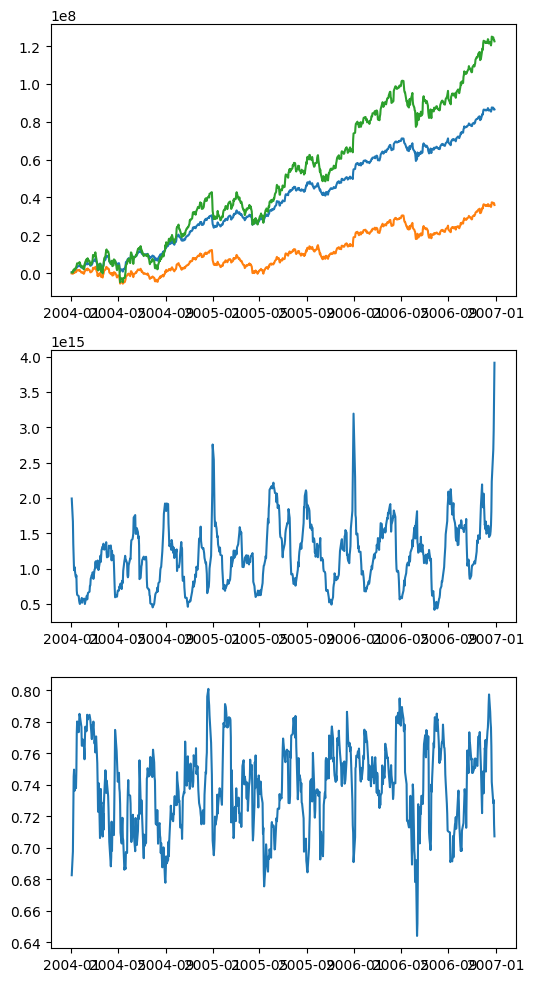

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1, figsize = (6, 12))
ax[0].plot(my_portfolio['long_mv'], label = 'Long Market Value')
ax[0].plot(my_portfolio['short_mv'], label = 'Short Market Value')
ax[0].plot(my_portfolio['cum_profit'], label = 'Cumulative Profit')

ax[1].plot(my_portfolio['risk'], label = 'Daily Risk')
ax[2].plot(my_portfolio['idio_risk_pctg'], label = 'Percentage of Idiosyncratic Risk')
plt.show()